# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

## Reading statistics

In [32]:
stats = pd.read_csv("/kaggle/input/image-dimensions/image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,widths,heights
count,2800.000000,2800.000000
mean,603.034286,647.997143
std,415.862944,446.696660
min,106.000000,115.000000
25%,313.000000,383.000000
50%,547.500000,589.500000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,546.000000,589.000000


## Helper functions

In [34]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [35]:
def build_model(width, height):
    model = keras.Sequential([
        layers.InputLayer(shape=(width, height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_48 (Rescaling)             │ (None, 546, 589, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_240 (Conv2D)                  │ (None, 544, 587, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_192 (MaxPooling2D)     │ (None, 272, 293, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_241 (Conv2D)                  │ (None, 270, 291, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_193 (MaxPooling2D)     │ (None, 135, 145, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_242 (Conv2D)                  │ (None, 133, 143, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_194 (MaxPooling2D)     │ (None, 66, 71, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_243 (Conv2D)                  │ (None, 64, 69, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_195 (MaxPooling2D)     │ (None, 32, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_244 (Conv2D)                  │ (None, 30, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_48 (Flatten)                 │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │         245,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,224,257 (4.67 MB)

 Trainable params: 1,224,257 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def plot_info(axes, type):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel("Loss")
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic")

In [37]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

## Undersampled dataset:

### Data inladen:

In [7]:
painters = ["Mondriaan", "Picasso"]
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/undersampled_dataset/undersampled_dataset", painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


### Model trainen

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss")]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

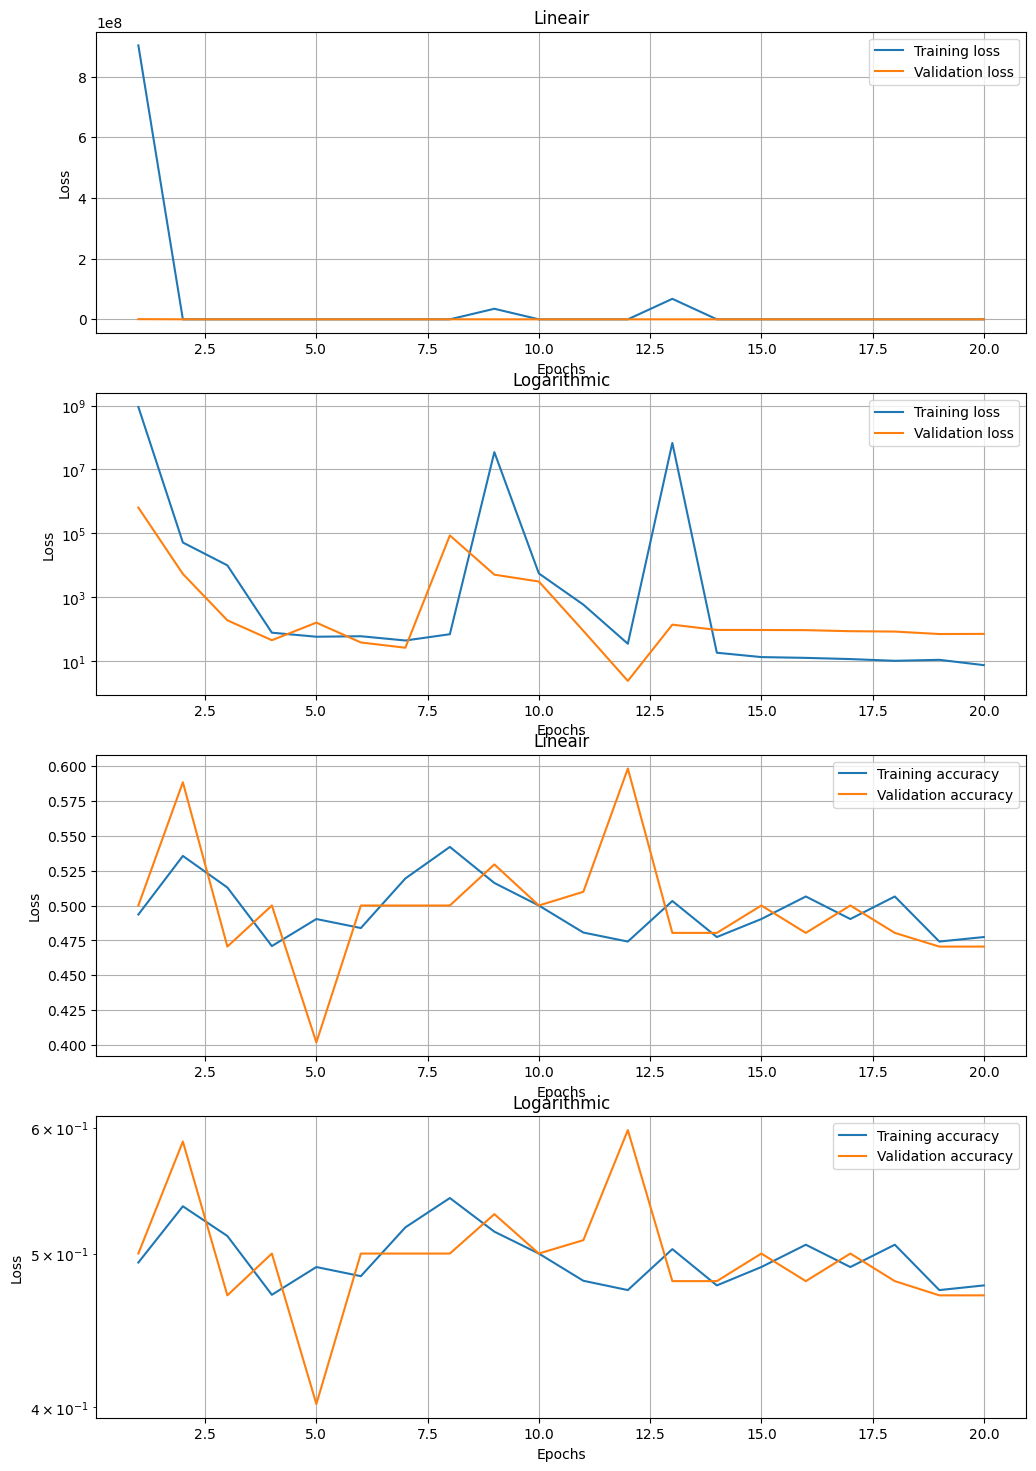

In [10]:
plot_loss(history)

In [11]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
              precision    recall  f1-score   support

           0       0.50      0.02      0.04        51
           1       0.50      0.98      0.66        51

    accuracy                           0.50       102
   macro avg       0.50      0.50      0.35       102
weighted avg       0.50      0.50      0.35       102



## Oversampled dataset

### loading data en model trainen

In [12]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/oversampled_dataset/oversampled_dataset", painters, median_height, median_width, batch_size=16)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.5060 - loss: 1.8156 - val_accuracy: 0.5754 - val_loss: 0.6871
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.6337 - loss: 0.6543 - val_accuracy: 0.7393 - val_loss: 0.5826
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.6956 - loss: 0.5635 - val_accuracy: 0.7262 - val_loss: 0.5552
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.7681 - loss: 0.5245 - val_accuracy: 0.8787 - val_loss: 0.3254
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.8899 - loss: 0.2689 - val_accuracy: 0.9049 - val_loss: 0.2685
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.9401 - loss: 0.2573 - val_accuracy: 0.9311 - val_loss: 0.3252
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9604 - loss: 0.1321 - va

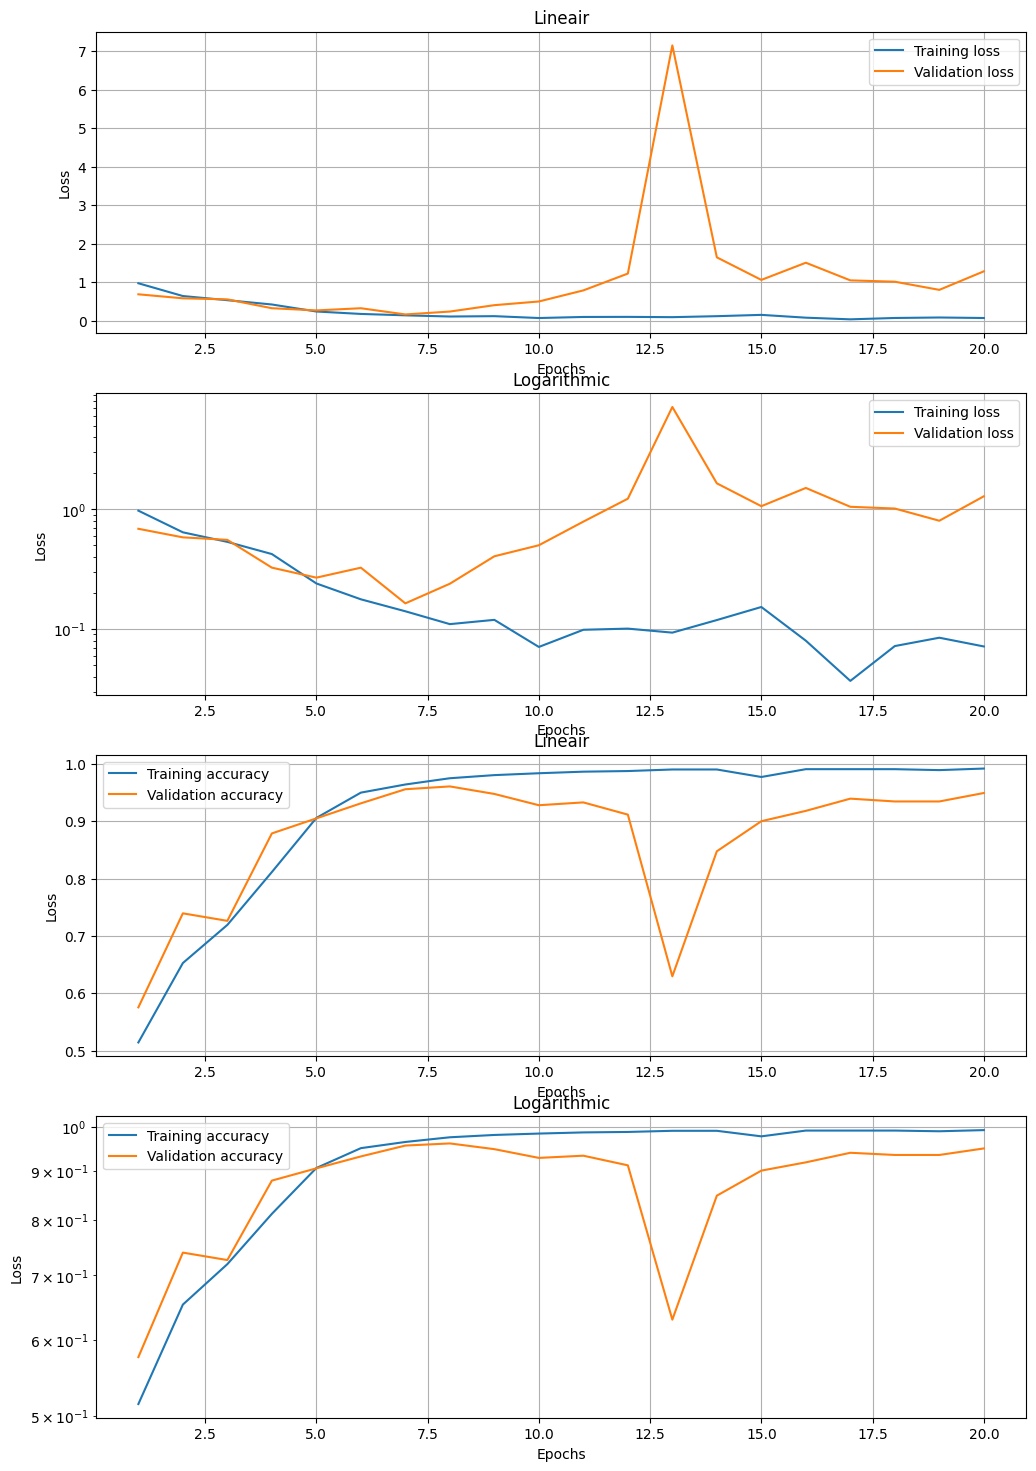

In [13]:
plot_loss(history)

In [14]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
              precision    recall  f1-score   support

           0       0.50      0.53      0.52       305
           1       0.50      0.48      0.49       305

    accuracy                           0.50       610
   macro avg       0.50      0.50      0.50       610
weighted avg       0.50      0.50      0.50       610



## imbalanced dataset

### loading dataset

In [15]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset", painters, median_width, median_height, batch_size=16)

Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


### Fitting model 

#### Class weights bepalen

Mondriaan = 0, Picasso = 1

In [16]:
train.class_names

['Mondriaan', 'Picasso']

In [17]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {0: 198, 1: 917})

Model trainen

In [18]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 2.8156565656565657, 1: 0.6079607415485279}

In [19]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.5548 - loss: 2.4266 - val_accuracy: 0.4070 - val_loss: 0.6947
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5529 - loss: 0.6976 - val_accuracy: 0.8383 - val_loss: 0.5755
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.5746 - loss: 0.7944 - val_accuracy: 0.5445 - val_loss: 0.6480
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.6357 - loss: 0.7218 - val_accuracy: 0.7305 - val_loss: 0.6069
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6814 - loss: 0.6314 - val_accuracy: 0.7978 - val_loss: 0.5372
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6470 - loss: 0.9219 - val_accuracy: 0.5633 - val_loss: 0.6353
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6858 - loss: 0.5370 - val_accuracy: 0.5256 - val_loss: 0.8034
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.7300 - loss: 0.5038 - val_accuracy: 0

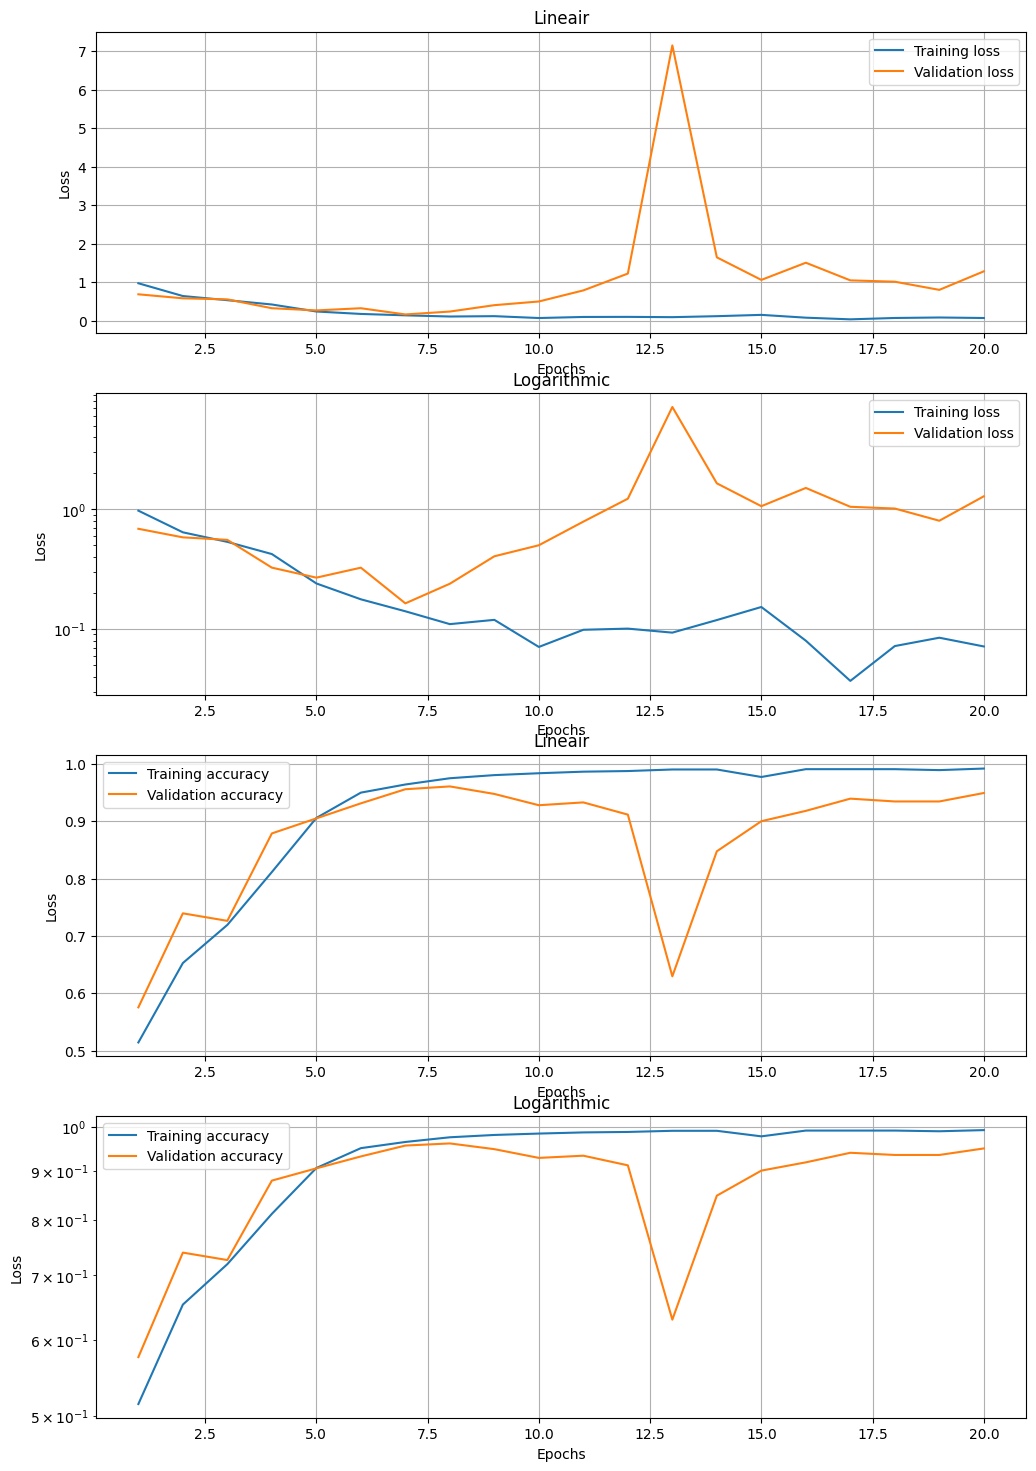

In [20]:
plot_loss(history)

In [21]:
y_pred = model.predict(test)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
print(classification_report(y_true, y_pred, zero_division=0))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
              precision    recall  f1-score   support

           0       0.16      0.14      0.15        66
           1       0.82      0.84      0.83       305

    accuracy                           0.72       371
   macro avg       0.49      0.49      0.49       371
weighted avg       0.70      0.72      0.71       371



Image size bepalen

In [23]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        y_pred = model.predict(test)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        test_accuracy = np.mean(y_pred.flatten() == y_true.flatten())
        
        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1_score": report["weighted avg"]["f1-score"],
            "support": report["weighted avg"]["support"]
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 115, 'train_accuracy': 0.9730941653251648, 'val_accuracy': 0.9460916519165039, 'test_accuracy': 0.7169811320754716, 'train_loss': 0.08880971372127533, 'val_loss': 0.2392391562461853, 'precision': 0.6930698943870891, 'recall': 0.7169811320754716, 'f1_score': 0.7044749636127506, 'support': 371}
min nearest
Found 1115 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 115, 'train_accuracy': 0.9739910364151001, 'val_accuracy': 0.9353099465370178, 'test_accuracy': 0.7250673854447439, 'train_loss': 0.0630464255809784, 'val_loss': 0.2041139155626297, 'precision': 0.718395670673353

In [26]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


In [28]:
df.sort_values("f1_score", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
19,median,lanczos5,546,589,0.956054,0.900270,0.743935,0.325256,0.728317,0.739318,0.743935,0.741584,371
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
34,75%,gaussian,800,826,0.961435,0.835580,0.714286,0.135784,0.589976,0.754514,0.714286,0.731434,371


In [29]:
df.sort_values("precisiondf.sort_values("f1_score", ascending=False).head(5)", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
34,75%,gaussian,800,826,0.961435,0.835580,0.714286,0.135784,0.589976,0.754514,0.714286,0.731434,371
19,median,lanczos5,546,589,0.956054,0.900270,0.743935,0.325256,0.728317,0.739318,0.743935,0.741584,371
13,25%,gaussian,313,383,0.952466,0.919137,0.719677,0.167471,0.474499,0.729380,0.719677,0.724378,371
23,mean,bicubic,603,647,0.944395,0.886792,0.706199,0.278986,0.705670,0.727496,0.706199,0.716171,371
33,75%,lanczos5,800,826,0.965919,0.897574,0.714286,0.185230,0.421453,0.727338,0.714286,0.720551,371


In [30]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
22,mean,nearest,603,647,0.984753,0.865229,0.789757,0.049925,3.372387,0.705031,0.789757,0.737357,371
32,75%,lanczos3,800,826,0.972197,0.948787,0.765499,0.058881,0.767852,0.708512,0.765499,0.732433,371
15,median,nearest,546,589,0.946188,0.943396,0.752022,0.294562,0.381559,0.719121,0.752022,0.733817,371
17,median,area,546,589,0.970404,0.929919,0.749326,0.144421,1.099276,0.705493,0.749326,0.724976,371
30,75%,bicubic,800,826,0.954260,0.948787,0.746631,0.201048,0.450455,0.699765,0.746631,0.720736,371


In [27]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,support
9,25%,bicubic,313,383,0.950673,0.946092,0.725067,0.169997,0.192346,0.687137,0.725067,0.704884,371
2,min,bicubic,106,115,0.959641,0.948787,0.706199,0.099885,0.194311,0.704445,0.706199,0.705319,371
1,min,nearest,106,115,0.973991,0.935310,0.725067,0.063046,0.204114,0.718396,0.725067,0.721667,371
0,min,bilinear,106,115,0.973094,0.946092,0.716981,0.088810,0.239239,0.693070,0.716981,0.704475,371
6,min,gaussian,106,115,0.979372,0.962264,0.743935,0.052606,0.243345,0.719174,0.743935,0.730594,371


In [31]:
df.to_csv("image_size_gridsearch_result.csv")